In [1]:
import re
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import numpy.linalg as LA
import pandas as pd
from nltk import word_tokenize
import json
import re

In [2]:
%cd anlp21
%cd data

[Errno 2] No such file or directory: 'anlp21'
/Users/josheverts/anlp21
/Users/josheverts/anlp21/data


In [3]:
glove_file= 'glove.6B.100d.100K.txt'
glove_in_w2v_format="../data/glove.6B.100d.100K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

/var/folders/p1/8wl2y7y5465_0xm59fxqrrnw0000gn/T/ipykernel_2492/615517611.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, glove_in_w2v_format)


In [4]:
glove = KeyedVectors.load_word2vec_format("../data/glove.6B.100d.100K.w2v.txt", binary=False)

In [22]:
## define functions to use

def get_semaxis_score(vectors, positive_terms=None, negative_terms=None, target_word=None):
    ## iter through pos and neg terms 
    ## average pos and neg and then subtract
    ## then find cosine sim between target_word vec and subtracted vec
    
    positive_vecs = []
    for i in positive_terms:
        positive_vecs.append(vectors[i])
        
    if len(positive_terms) > 1:
        mean_pos = np.mean(positive_vecs, axis = 0)
    
    negative_vecs = []
    for i in negative_terms:
        negative_vecs.append(vectors[i])
    
    if len(negative_terms) > 1:
        mean_neg = np.mean(negative_vecs, axis = 0)
    
    v_axis = mean_pos - mean_neg
    score = glove.cosine_similarities(vectors[target_word], [v_axis])[0]
    
    # your code here
    
    # score should be a single real-value number (e.g., 0.342)
    return score


## now try total embedding on new semaxis for both comments and news
def new_score_single_news(df, positive_terms, negative_terms, vecs):
    token_count = 0
    for i in range(len(df)):

        text = df.iloc[i].text
        text = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',text).strip()
        tokens = word_tokenize(text.lower())
        embeddings = []
        for token in tokens[:50]:
            if token in vecs and token not in stopwords:
                embeddings.append(get_semaxis_score(vecs, positive_terms, negative_terms, token))
                token_count+=1
    print(token_count)
    std = np.std(embeddings)
    mean = np.mean(embeddings)

    return mean, std

def new_score_single_comments(df, positive_terms, negative_terms, vecs):
    
    scores = []
    token_count = 0
    for thread in df_comments['comments']:
        for comment in thread:
            comment = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',comment).strip()
            tokens = word_tokenize(comment.lower())
            for token in tokens[:50]:
                if token in vecs and token not in stopwords:
                    sem_score = get_semaxis_score(vecs, positive_terms, negative_terms, token)
                    scores.append(sem_score)
                    token_count+=1
    print(token_count)
    std = np.std(scores)
    mean_score = np.mean(np.array(scores))

    return mean_score, std


In [5]:
df_news = pd.read_pickle('/Users/josheverts/Documents/EV_news.pkl')

In [211]:
df_news_cleaned = df_news.drop_duplicates(subset='text')
df_news_cleaned.to_csv('/Users/josheverts/Documents/EV_news.csv')

In [195]:
## use nltk stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = stopwords + ['like', "n't", 'would', 'said', "'", "'s", 'see', "'m'", "wilson", "`"]

In [196]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [197]:
## train word2vec model on news data 
sentences_news = []
for article in df_news_cleaned['text']:
    # remove punctuation
    article = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',article).strip()
    # tokenizer
    tokens = word_tokenize(article.lower())
    cleaned = []
    for token in tokens:
        if token not in stopwords:
            cleaned.append(token)
            
    if len(cleaned) > 1:
        sentences_news.append(cleaned)

from gensim.models import Word2Vec
news_model = Word2Vec(sentences_news, min_count=3, vector_size=50, sg = 1, window=7,epochs=40)       # Number of epochs training over corpus

In [198]:
news_model.wv.most_similar('disruptor')
## interesting words autopilot, ev, musk, tesla, electric, charging, lithium, battery
## negative: 'waste', 'crash', 'faulted', 'brine'
## positive: 'fast', 'charging', 'convenient', 'disruptor'

[('attendees', 0.6509857177734375),
 ('wed', 0.6395744681358337),
 ('cnbc', 0.6391957402229309),
 ('0050', 0.6247893571853638),
 ('chose', 0.6244986653327942),
 ('150th', 0.6224596500396729),
 ('drone', 0.6200670599937439),
 ('et', 0.6159351468086243),
 ('pa', 0.6105039715766907),
 ('943', 0.6100491285324097)]

In [199]:
news_model.wv.most_similar('ev')

[('coownership', 0.7215216755867004),
 ('gasengine', 0.7173218727111816),
 ('1000012000', 0.7168545722961426),
 ('massmarketed', 0.689332127571106),
 ('recycle', 0.6774697303771973),
 ('emanating', 0.6743977665901184),
 ('toko', 0.6658390164375305),
 ('takaoka', 0.6636896729469299),
 ('vehicle', 0.6614313125610352),
 ('convenient', 0.6606936454772949)]

In [200]:
positive_news = ['fast', 'charging', 'convenient', 'disruptor']
negative_news = ['waste', 'crash', 'faulted', 'lithium']
target_words = ['california', 'shanghai', 'chicago', 'range', 'delay']
news_vectors = news_model.wv

for word in target_words:
    print(word, get_semaxis_score(news_vectors, positive_news, negative_news, word))
    
    

musk -0.07147405
ev 0.17120804
ice -0.0056759464
range 0.20055206
delay -0.13315907


In [201]:
## read in cleaned comments
df_comments = pd.read_csv('/Users/josheverts/all-cleaned-comments.csv')

In [202]:
## now retrain word2vec on comments 
sentences_comments = []
# count=0
for thread in df_comments['comments']:
    for comment in thread:
    # remove punctuation
        comment = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',comment).strip()
    # tokenizer
        tokens = word_tokenize(comment.lower())
        cleaned = []
        for token in tokens: 
            if token not in stopwords:
                cleaned.append(token)
                
    if len(cleaned) > 1:
        sentences_comments.append(cleaned)
#     count+=1
#     print(count/len(df_comments))
comments_model = Word2Vec(sentences_news, min_count=3, vector_size=50, sg = 1, window=7,epochs=40)       # Number of epochs training over corpus

In [203]:
positive_news = ['fast', 'charging', 'convenient', 'disruptor']
negative_news = ['waste', 'crash', 'faulted', 'lithium']
target_words = ['musk', 'ev', 'ice', 'range', 'delay']
comments_vectors = comments_model.wv

for word in target_words:
    print(word, get_semaxis_score(comments_vectors, positive_news, negative_news, word))

musk -0.06549572
ev 0.20182215
ice 0.018702216
range 0.18277398
delay -0.13769653


In [204]:
## now try total embedding on new semaxis for both comments and news
def new_score_single_news(df, positive_terms, negative_terms, vecs):
    token_count = 0
    for i in range(len(df)):

        text = df.iloc[i].text
        text = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',text).strip()
        tokens = word_tokenize(text.lower())
        embeddings = []
        for token in tokens:
            if token in vecs and token not in stopwords:
                embeddings.append(get_semaxis_score(vecs, positive_terms, negative_terms, token))
                token_count+=1
    print(token_count)
    std = np.std(embeddings)
    mean = np.mean(embeddings)

    return mean, std

def new_score_single_comments(df, positive_terms, negative_terms, vecs):
    
    scores = []
    token_count = 0
    for comment in df_comments['comments']:
        comment = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',comment).strip()
        tokens = word_tokenize(comment.lower())
        for token in tokens:
            if token in vecs and token not in stopwords:
                sem_score = get_semaxis_score(vecs, positive_terms, negative_terms, token)
                scores.append(sem_score)
                token_count+=1
    print(token_count)
    std = np.std(scores)
    mean_score = np.mean(np.array(scores))

    return mean_score, std

In [205]:
positive_news = ['fast', 'charging', 'convenient', 'disruptor']
negative_news = ['waste', 'crash', 'faulted', 'lithium']
df_news = df_news_cleaned

In [206]:
news_score_comments = new_score_single_news(df_news, positive_news, negative_news, comments_vectors)

657017


In [207]:
news_score_news = new_score_single_news(df_news, positive_news, negative_news, news_vectors)

657017


In [208]:
comments_score_comments = new_score_single_comments(df_comments, positive_news, negative_news, comments_vectors)

81262


In [209]:
comments_score_news = new_score_single_comments(df_comments, positive_news, negative_news, news_vectors)

81262


In [210]:
# original
print("news_comments: %.3f | %.3f, news_news: %.3f |%.3f, \n, comments_comments: %.3f |%.3f, comments_news: %.3f |%.3f" \
      %(news_score_comments[0],news_score_comments[1],
        news_score_news[0],  news_score_news[1], 
        comments_score_comments[0], comments_score_comments[1],
        comments_score_news[0], comments_score_news[1]))

news_comments: -0.015 | 0.109, news_news: -0.023 |0.121, 
, comments_comments: -0.056 |0.141, comments_news: -0.054 |0.141


In [53]:
# ## after adding stopwords
# print("news_comments: %.3f | %.3f, news_news: %.3f |%.3f, \n, comments_comments: %.3f |%.3f, comments_news: %.3f |%.3f" \
#       %(news_score_comments[0],news_score_comments[1],
#         news_score_news[0],  news_score_news[0], 
#         comments_score_comments[0], comments_score_comments[1],
#         comments_score_news[0], comments_score_news[1]))

news_comments: -0.043 | 0.096, news_news: -0.045 |-0.045, 
, comments_comments: -0.037 |0.135, comments_news: -0.037 |0.135


In [44]:
# ## after changing sentiment vectors to len(2)
# print("news_comments: %.3f | %.3f, news_news: %.3f |%.3f, \n, comments_comments: %.3f |%.3f, comments_news: %.3f |%.3f" \
#       %(news_score_comments[0],news_score_comments[1],
#         news_score_news[0],  news_score_news[0], 
#         comments_score_comments[0], comments_score_comments[1],
#         comments_score_news[0], comments_score_news[1]))

news_comments: -0.043 | 0.096, news_news: -0.045 |-0.045, 
, comments_comments: -0.012 |0.102, comments_news: -0.020 |0.104


In [45]:
# ## only take first fifty tokens
# ## fixed issue in news score print (will need to rerun the previous ones under their conditions)
# print("news_comments: %.3f | %.3f, news_news: %.3f |%.3f, \n, comments_comments: %.3f |%.3f, comments_news: %.3f |%.3f" \
#       %(news_score_comments[0],news_score_comments[1],
#         news_score_news[0],  news_score_news[1], 
#         comments_score_comments[0], comments_score_comments[1],
#         comments_score_news[0], comments_score_news[1]))



news_comments: -0.043 | 0.096, news_news: -0.045 |0.097, 
, comments_comments: -0.012 |0.102, comments_news: -0.020 |0.104


In [183]:
t_stat = (news_score_comments[0] - comments_score_comments[0]) / (np.sqrt(news_score_comments[1]**2/59370 + comments_score_comments[1]**2/38410))

In [ ]:
## F-test shows statistically significant difference in variance between the groups (news_comments vs comments_comments)
## t-test shows statistically significant difference in means between the groups (news_comments vs comments_comments)

In [78]:
## now try to visualize news and comments vectors 
def news_embeddings(df, vecs):
    token_count = 0
    means = []
    for i in range(len(df)):

        text = df.iloc[i].text
        text = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',text).strip()
        tokens = word_tokenize(text.lower())
        embeddings = []
        for token in tokens:
            if token in vecs and token not in stopwords:
                embeddings.append(vecs[token])
        means.append(np.mean(embeddings, axis = 0))
        token_count+=1
#         print(token_count/len(df))

#     std = np.std(embeddings)
#     mean = np.mean(embeddings, axis = 0)

    return means

def comments_embeddings(df, vecs):
    
    means = []
    token_count = 0
    for comment in df_comments['comments']:

        comment = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',comment).strip()
        tokens = word_tokenize(comment.lower())
        embeddings = []
        for token in tokens:
            if token in vecs and token not in stopwords:
                embeddings.append(vecs[token])
#             print(embeddings)

#     std = np.std(scores)
        token_count+=1
#             print(token_count/1800)
#             print(np.mean(embeddings, axis = 0))
        if len(embeddings) != 0:
            means.append(np.mean(embeddings, axis = 0))

    return means



In [79]:
news_embed = news_embeddings(df_news, news_vectors)
comments_embed = comments_embeddings(df_comments, news_vectors)

In [80]:
## pca of word2vecs
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
news_pca = pca.fit_transform(news_embed)[:,:3]
comments_pca = pca.fit_transform(comments_embed)[:,:3]

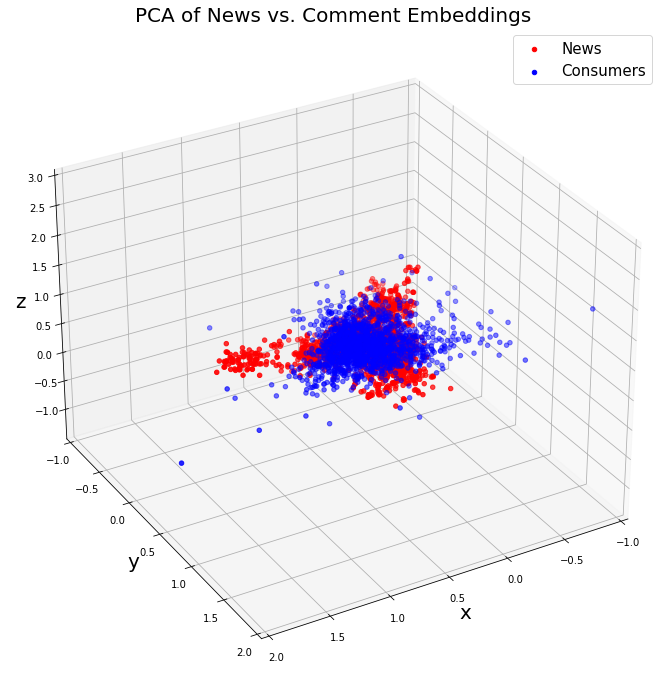

In [84]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (18,12))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 60)
ax.scatter(news_pca[:,0], news_pca[:,1], news_pca[:,2], c = 'r', label = 'News')
ax.scatter(comments_pca[:,0], comments_pca[:,1], comments_pca[:,2], c = 'b', label = 'Consumers')

ax.set_title("PCA of News vs. Comment Embeddings", size = 20)
ax.set_xlabel('x', size = 20)
ax.set_ylabel('y', size = 20)
ax.set_zlabel('z', size = 20)
ax.set_ylim(-1,2)
ax.set_xlim(-1,2)
plt.legend(fontsize = 15)




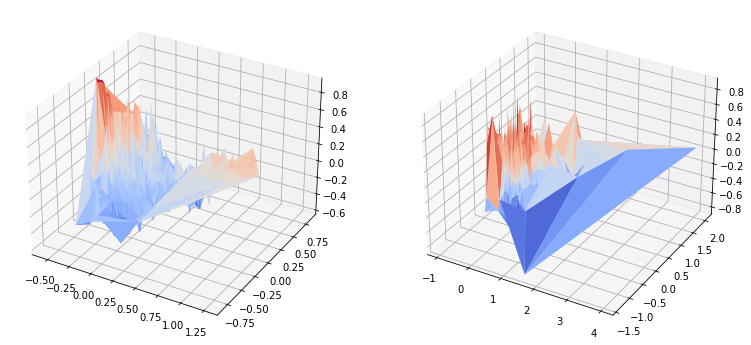

In [281]:
## plot surface 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import griddata


fig, (ax1,ax2) = plt.subplots(1,2,subplot_kw={"projection": "3d"}, figsize = (13,8))

# Make data.
X = news_pca[:,0]
Y = news_pca[:,1]
Z = news_pca[:,2]
surf = ax1.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, linewidth=1, antialiased=True)

X = comments_pca[:,0]
Y = comments_pca[:,1]
Z = comments_pca[:,2]
surf = ax2.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, linewidth=1, antialiased=True)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

In [322]:
## try topic model for news vs comments 
import gensim
from gensim import corpora
import operator

## from topic models homework in eda
def filter(word, stopwords):
    
    """ Function to exclude words from a text """
    
    # no stopwords
    if word in stopwords:
        return False
    
    # has to contain at least one letter
    if re.search("[A-Za-z]", word) is not None:
        return True
    
    return False






In [137]:
## now try to visualize news and comments vectors 
stopwords = stopwords + ['like', "n't", 'would', 'said', "'", "'s", 'see', "'m'", "wilson", "`"]
def news_tokens(df):
    token_count = 0
    docs = []
    for i in range(len(df)):

        text = df.iloc[i].text
        text = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',text).strip()
        tokens = word_tokenize(text.lower())
        filtered = []
        for token in tokens:
            if token not in stopwords:
                filtered.append(token)
        docs.append(filtered)        
#         print(token_count/len(df))

#     std = np.std(embeddings)
#     mean = np.mean(embeddings, axis = 0)

    return docs

def comments_tokens(df):
    
    docs = []
    token_count = 0
    for comment in df_comments['comments']:

        comment = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',comment).strip()
        tokens = word_tokenize(comment.lower())
        filtered = []
        for token in tokens:
            if token not in stopwords:
                filtered.append(token)
        docs.append(filtered)

    return docs

In [138]:
news = news_tokens(df_news)
comments = comments_tokens(df_comments)

In [139]:
from gensim import corpora
dictionary_news = corpora.Dictionary(news)
dictionary_news.filter_extremes(no_below=5, no_above=.5, keep_n=10000)
corpus_news = [dictionary_news.doc2bow(text) for text in news]

In [140]:
dictionary_comments = corpora.Dictionary(comments)
dictionary_comments.filter_extremes(no_below=5, no_above=.5, keep_n=10000)
corpus_comments = [dictionary_comments.doc2bow(text) for text in comments]

In [141]:
news_tm = gensim.models.ldamodel.LdaModel(corpus=corpus_news,
                                           id2word=dictionary_news,
                                           num_topics=20, 
                                           passes=30,
                                           alpha='auto')

In [142]:
comments_tm = gensim.models.ldamodel.LdaModel(corpus=corpus_comments,
                                           id2word=dictionary_comments,
                                           num_topics=20, 
                                           passes=30,
                                           alpha='auto')

In [165]:
for i in range(20):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in news_tm.show_topic(i, topn=12)])))

topic 0:	oil energy prices demand bp shell gas growth price production years investors
topic 1:	fund sp stock million 500 • fell points index investors capital firm
topic 2:	cobalt ford battery glencore supply batteries billion congo metal china production tonnes
topic 3:	sales cars vw billion volkswagen motor auto brand euros models nissan automakers
topic 4:	china trade chinese billion trump beijing tariffs companies technology products million foreign
topic 5:	toyota motor cars tunnel china musk gac boring city los angeles fuel
topic 6:	revenue production 2017 per million q1 cash nickel cobalt software net 18
topic 7:	gm battery barra detroit billion automaker chinese china united automakers general eon
topic 8:	tesla nickel crash autopilot driver system fire police model battery safety may
topic 9:	copper stocks lme european gmt aluminium earnings month profit markets metals three
topic 10:	trump administration fuel rules california standards platinum could states industry automake

In [ ]:
categories = ['car comparison and review', 'build quality', 'warranty and service', 'charging and battery and range'
             'cold weather concerns', 'tesla stock and car production', 'autopilot', 'environment']
car_comparison = {0:'autopilot', 1:'autopilot', 2:['sales', 'car comparison'], 3: 'build quality', 
                 4: 'tesla stock and car production', 5: 'cold weather concerns', 6: 'environment', 
                 7: 'tesla stock and car production', 8: 'tesla stock and car production', 9:'warranty and service',
                 10: ['build quality', 'service'], 11: 'tesla stock and car prodcution', 12: 'tesla stock and car production', 
                 13: 'tesla stock and car production', 14: 'charging and battery and range', 15: 'car comparison', 
                 16: 'car comparison', 17: 'cold weather concerns', 18: 'cold weather concerns', 19: 'car comparison and review'}

In [153]:
positive_news = ['fast', 'charging', 'convenient', 'disruptor']
negative_news = ['waste', 'crash', 'faulted', 'lithium']

overall_news = []
for i in range(20):
    terms = [term for term, freq in news_tm.show_topic(i, topn=13)]
    sentiments = []
    for term in terms:
        if term in news_vectors:
            sentiment = get_semaxis_score(news_vectors, positive_news, negative_news, term)
            sentiments.append(sentiment)
    overall_news.append(np.mean(sentiments))
                    


In [154]:
sorted(overall_news)

[-0.31763265,
 -0.29555914,
 -0.17774123,
 -0.15407658,
 -0.14707527,
 -0.14056699,
 -0.123030275,
 -0.10026346,
 -0.08158859,
 -0.07141067,
 -0.05758999,
 -0.053480193,
 -0.03434461,
 -0.032308612,
 -0.010514436,
 -0.010103597,
 0.026649594,
 0.0282208,
 0.03612567,
 0.05000844]

In [155]:
average_sentiment_news = np.mean(sentiments)

In [180]:
positive_news = ['fast', 'charging', 'convenient', 'disruptor'] ## baby chosen as similar to disruptor embedding
negative_news = ['waste', 'crash', 'faulted', 'lithium']

overall_comments = []
for i in range(20):
    terms = [term for term, freq in comments_tm.show_topic(i, topn=13)]
    sentiments = []
    for term in terms:
        if term in comments_vectors:
            sentiment = get_semaxis_score(comments_vectors, positive_news, negative_news, term)
            sentiments.append(sentiment)
    overall_comments.append(np.mean(sentiments))

In [157]:
sorted(overall_comments)

[-0.16485249,
 -0.13939995,
 -0.13575819,
 -0.13256647,
 -0.12628935,
 -0.100850485,
 -0.09974727,
 -0.09341074,
 -0.08281464,
 -0.07534946,
 -0.072391205,
 -0.06885619,
 -0.06771488,
 -0.06727856,
 -0.05046988,
 -0.048360273,
 -0.032916658,
 -0.031604376,
 -0.025416944,
 0.010533054]

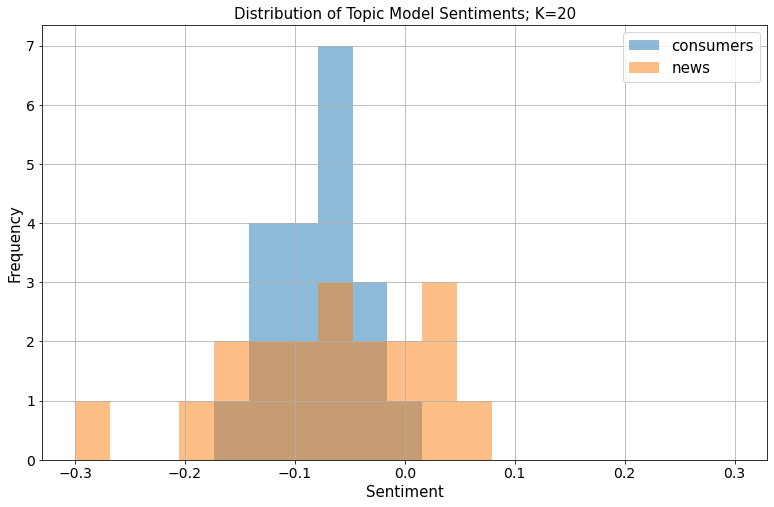

In [168]:
bins = np.linspace(-.3,.3,20)
fig = plt.figure(figsize = (13,8))
plt.hist(overall_comments,bins=bins, alpha = .5, label = 'consumers')
plt.hist(overall_news, bins = bins, alpha = .5, label = 'news')
plt.legend(fontsize = 15)
plt.xlabel('Sentiment', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title('Distribution of Topic Model Sentiments; K=20', size = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

In [ ]:
average_sentiment_comments = np.mean(sentiments)

In [ ]:
print(average_sentiment_news, average_sentiment_comments)

In [394]:
for i in range(10):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in comments_tm.show_topic(i, topn=15)])))

topic 0:	model ’ 3 that s on tesla for with we more as but you was
topic 1:	not but have at would was trip on n't you for power as with an
topic 2:	that tesla 's for model but 3 will n't as they on this are or
topic 3:	was for on charge charging but range this battery we 3 mi model so one
topic 4:	you wilson bob for my have 3 model ↑ said 's that we now this
topic 5:	with for you be that have my car can are an from this they as
topic 6:	tires front with on for tire winter rear my this model weight rolling motor would
topic 7:	you be speed bob so are car wilson lane can but that not if will
topic 8:	miles you range with at ' wilson that bob for driving or on but have
topic 9:	that have tesla for car with 's not they said you are ↑ on n't


In [176]:
def get_semaxis_score(vectors, positive_terms=None, negative_terms=None, target_word=None):
    ## iter through pos and neg terms 
    ## average pos and neg and then subtract
    ## then find cosine sim between target_word vec and subtracted vec
    
    positive_vecs = []
    for i in positive_terms:
        positive_vecs.append(vectors[i])
        
    if len(positive_terms) > 1:
        mean_pos = np.mean(positive_vecs, axis = 0)
    
    negative_vecs = []
    for i in negative_terms:
        negative_vecs.append(vectors[i])
    
    if len(negative_terms) > 1:
        mean_neg = np.mean(negative_vecs, axis = 0)
    
    v_axis = mean_pos - mean_neg
    score = glove.cosine_similarities(vectors[target_word], [v_axis])[0]
    
    # your code here
    
    # score should be a single real-value number (e.g., 0.342)
    return score



In [187]:
## get semaxis scores for words in doc 

positive_terms = ['energy-efficient', 'revolutionary']
negative_terms = ['overpriced', 'inconvenient']

def new_score(df, positive_terms, negative_terms):
    
    stds = []
    total_vecs = []
    for i in range(len(df)):

        text = df.iloc[i].text
        tokens = word_tokenize(text)

        embeddings = []
        for token in tokens:
            if token in glove:
                if token not in stopwords:
                    embeddings.append(get_semaxis_score(glove, positive_terms, negative_terms, token))
        stds.append(np.std(embeddings))
        summed = np.mean(np.vstack(np.array(embeddings)), axis = 0)
        total_vecs.append(summed)
    return total_vecs, stds

def new_score_single(df, positive_terms, negative_terms):

    
    for i in range(len(df)):

        text = df.iloc[i].text
        tokens = word_tokenize(text)
        embeddings = []
        for token in tokens:
            if token in glove:
                if token not in stopwords:
                    embeddings.append(get_semaxis_score(glove, positive_terms, negative_terms, token))
    std = np.std(embeddings)
    mean = np.mean(embeddings)

    return mean, std

def new_score_single_comments(df, positive_terms, negative_terms):

    
    for i in range(len(df)):

        text = df.iloc[i].comments
        tokens = word_tokenize(text)
        embeddings = []
        for token in tokens:
            if token in glove:
                if token not in stopwords:
                    embeddings.append(get_semaxis_score(glove, positive_terms, negative_terms, token))
    std = np.std(embeddings)
    mean = np.mean(embeddings)

    return mean, std


In [190]:
positive_news = ['fast', 'charging', 'convenient', 'baby'] ## baby chosen as similar to disruptor embedding
negative_news = ['waste', 'crash', 'faulted', 'lithium']
glove_news = new_score_single(df_news, positive_news, negative_news)
glove_comments = new_score_single_comments(df_comments, positive_news, negative_news)

In [194]:
print("mean_news %.2f, std_news %.3f, mean_comments %.2f, std_comments %.3f" %(glove_news[0], glove_news[1],
                                                                              glove_comments[0], glove_comments[1]))

mean_news 0.10, std_news 0.094, mean_comments 0.18, std_comments 0.123


In [226]:
df_comments['dates'] = df_comments['dates'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True, errors = 'coerce')) 

In [237]:
df_comments = df_comments.dropna()
df_comments['year'] = df_comments['dates'].apply(lambda x: x.year)
# df_grouped = df_comments.groupby(df_comments['dates'].dt.year).count()

,Unnamed: 0,comments,dates,year
0,0,I noticed that the recent October 2022 iZEV el...,2021-10-29,2021
5,5,Anyone want to place betting odds on a Biden E...,2021-01-19,2021
6,6,I don't think Tesla would raise the price of t...,2021-01-19,2021
7,7,marswould raise the price of their vehicles. I...,2021-01-19,2021
8,8,I guess we will see. If there is any price inc...,2021-01-19,2021
...,...,...,...,...
1623,1671,"Thanks, Josh!",2017-10-13,2017
1624,1672,Good news! The first 2nd hand Tesla Model 3 is...,2017-10-11,2017
1625,1673,"I'd only pay $148,500. It doesn't have the spo...",2017-10-11,2017
1626,1674,Looks like it's been pulled from Craigslist. T...,2017-10-11,2017


car people cars one ’ far tesla better line autopilot



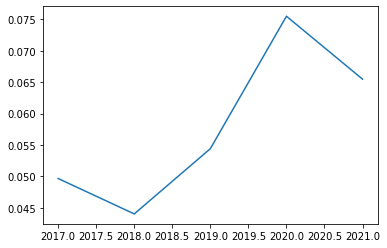

fsd tesla 'm using car also used charger autopilot one



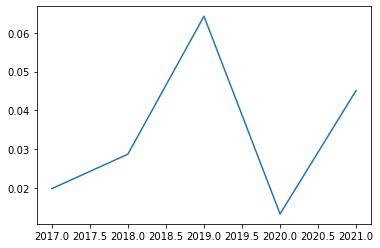

model 3 tesla sales 2018 2017 end month news camry



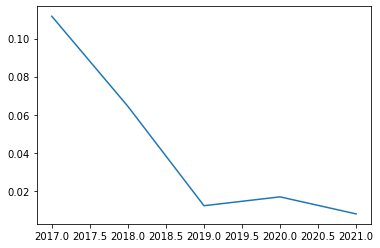

paint part new looks parts think still also get know



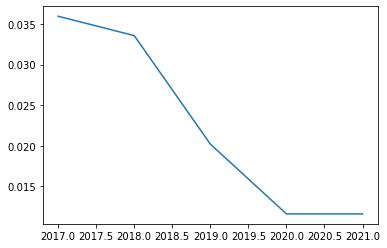

tesla model 3 days production one time line week per



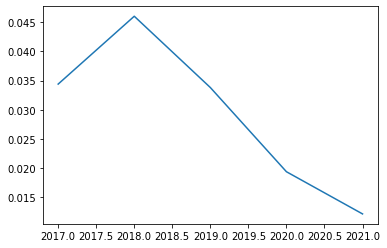

battery tires temperature know range v charging pack car tesla



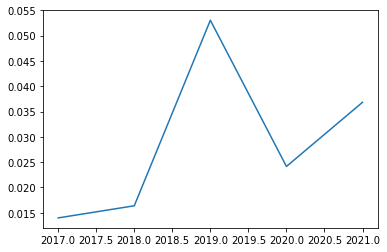

nuclear one waste good new fuel energy years plants us



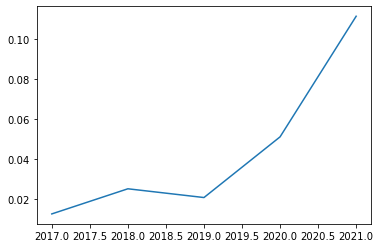

tesla people car get evs 3 delivery model time really



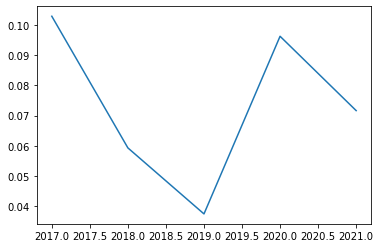

tesla production model week think 3 bloomberg also numbers time



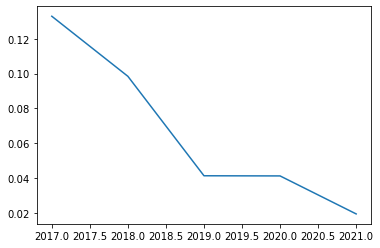

tesla car cars one even much service model make forum



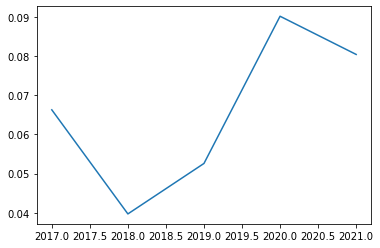

car tesla service 3 never one quality poor something model



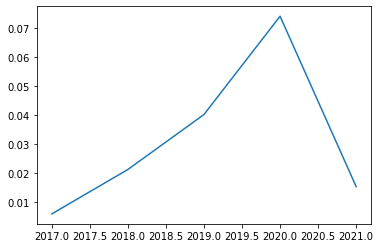

model 3 tesla production rate reservations month x year week



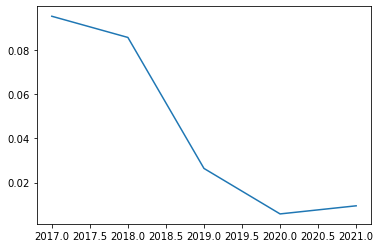

regen bolt driving car 3 tesla youtube never go model



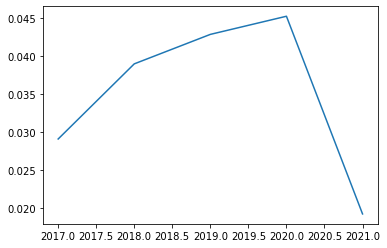

production tesla numbers model week going 'm 3 curve 2018



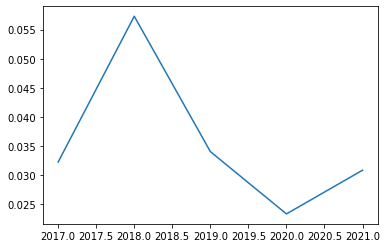

range car charge miles charging model 3 driving supercharger tesla



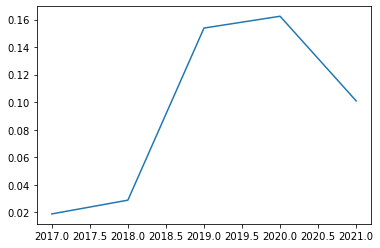

model 3 'm munro car photos mtn posted video front



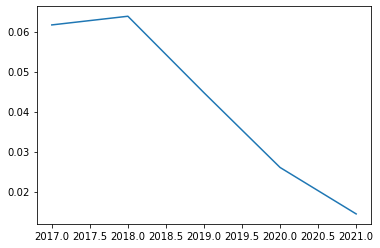

car tesla electric ford energy 'm speed article even range



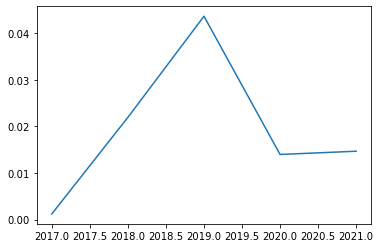

tesla model 3 price sales get us range ev awd



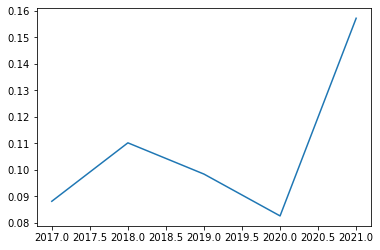

’ model tesla car 3 heat motor well use also



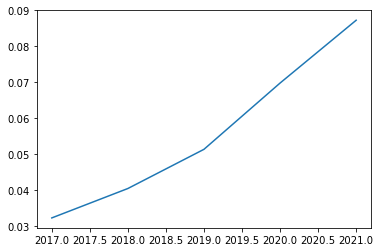

got one 3 black get color tesla model using 'll



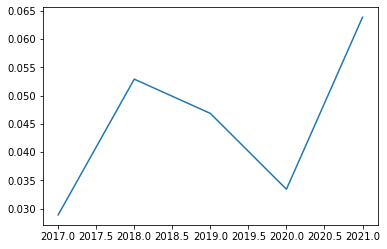

In [251]:
topic_model=comments_tm

start=2017
end=2022

window=end-start

topic_docs=[]
total_mass=np.zeros(window)
K=20
for i in range(K):
    topic_docs.append(np.zeros(window))
    
for doc_id in range(len(df_comments)):
    doc_topics=topic_model.get_document_topics(corpus_comments[doc_id])
    year = df_comments.iloc[doc_id]['year']
    total_mass[year-start]+=1
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][year-start]+=topic_prob

for i in range(K):
    print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=10)]))
    plt.plot(range(2017,2022), topic_docs[i]/total_mass)
    plt.show()

In [ ]:
## deliveries ind 6
## production ind 7
## mach-e 16


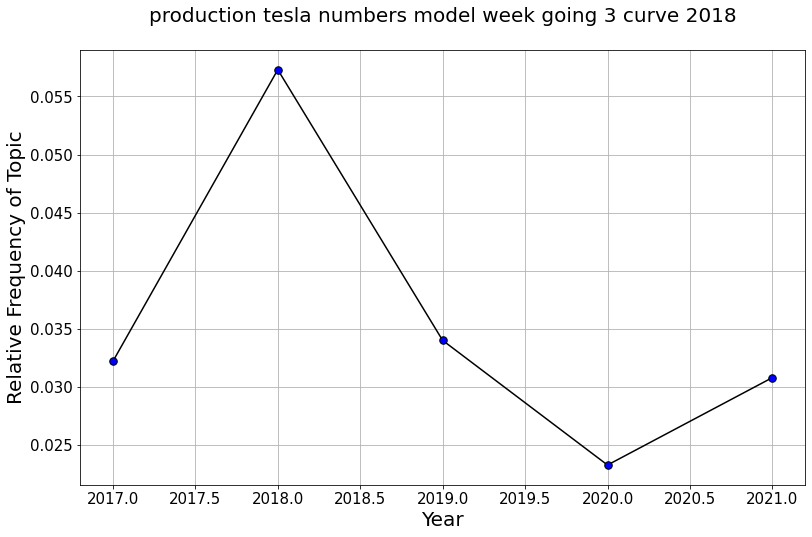

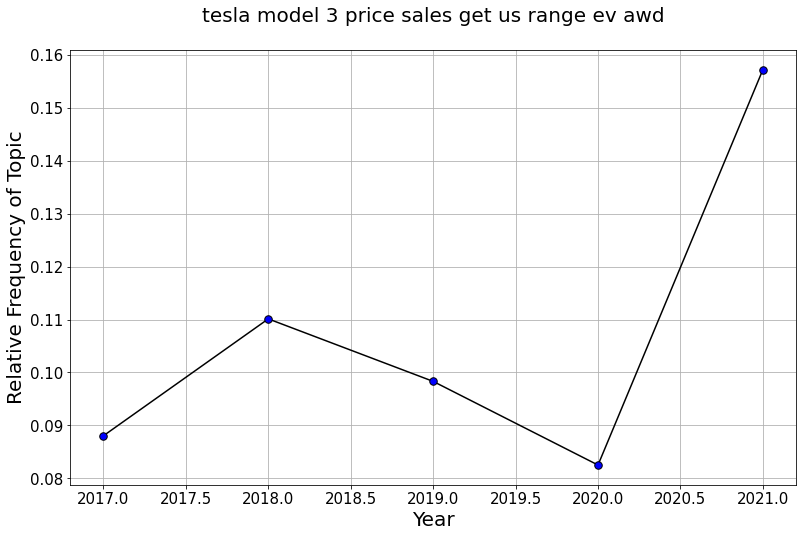

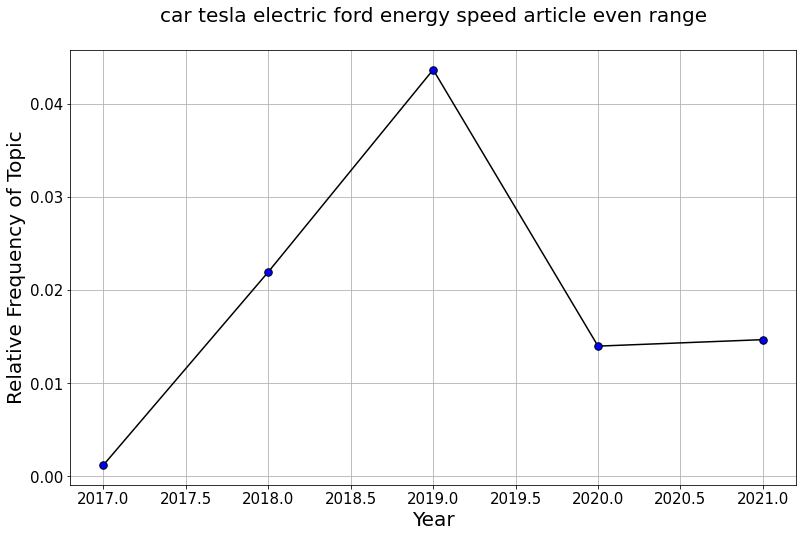

In [266]:
## make these plots: 
indx  = [13,17,16]
for i in indx: 
    fig = plt.figure(figsize = (13,8))
    plt.title("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=10) if term != "'m"] ), size = 20)
    plt.plot(range(2017,2022), topic_docs[i]/total_mass, '.-', c = 'k', mfc = 'blue', markersize = 15)
    plt.xlabel('Year', size = 20)
    plt.ylabel('Relative Frequency of Topic', size = 20)
    plt.grid()
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

In [267]:
## try to extract geographic entities and their sentiments like from class 
text = ''
for i in range(len(df_news)):
    doc = df_news.iloc[i].text
    text+=doc


In [277]:
## make spacy doc and get geo ents
import spacy
from collections import Counter
locations=Counter()
nlp = spacy.load('en_core_web_sm', disable=['parser'])
chunks = list([text[0:999998],text[999998:999998*2],text[999998*2:999998*3], 
               text[999998*4:999998*5],text[999998*5:999998*6],text[999998*6:]])
for chunk in chunks:
    doc = nlp(chunk)
    for entity in doc.ents:
        # We'll select just entities that are tagged geopolitical entities (which include cities)
        if entity.label_ == "GPE":
            locations[entity.text.lower()]+=1

In [282]:
import operator
sorted_locations = sorted(locations.items(), key=operator.itemgetter(1), reverse = True)

In [306]:
location_sents = []
temp = 0
sent = 0
for loc in sorted_locations[:5]:
    if loc[0] == 'u.s':
        temp = 'usa'
        sent = get_semaxis_score(news_vectors, positive_news, negative_news, temp)
        location_sents.append(sent)
    else:
        location_sents.append(get_semaxis_score(news_vectors, positive_news, negative_news, loc[0]))

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

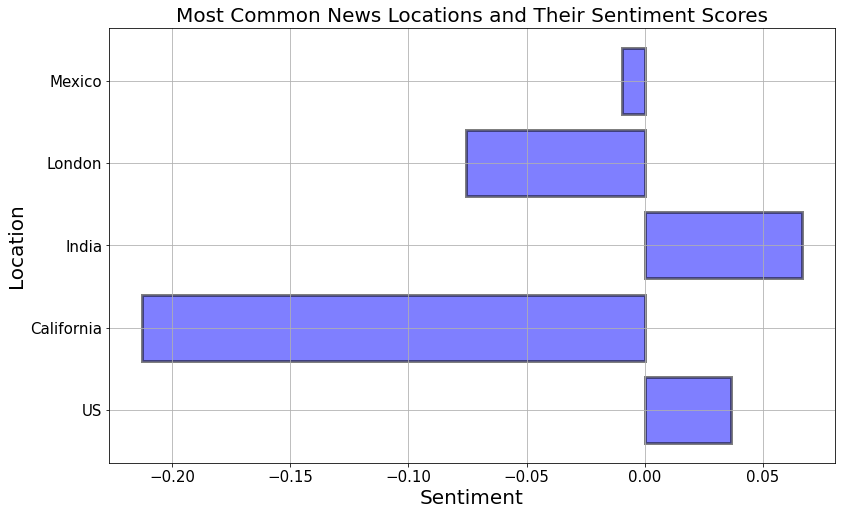

In [319]:
fig = plt.figure(figsize = (13,8))
labels = ['US', 'California', 'India', 'London', 'Mexico']
plt.barh(labels, location_sents, facecolor = 'blue', edgecolor='black', lw = 3, alpha = .5)
plt.title("Most Common News Locations and Their Sentiment Scores", size = 20)
plt.xlabel('Sentiment', size = 20)
plt.ylabel('Location', size = 20)
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [243]:
topic_model.get_document_topics(df_comments['comments'][0])

ValueError: not enough values to unpack (expected 2, got 1)

In [88]:
## get semaxis scores for all documents belonging to a particular news org
df_grouped = df_news.groupby(['site'])['text'].apply('   '.join).reset_index()

In [133]:
vals, stds = new_score(df_grouped, positive_terms, negative_terms)
vals = [i[0] for i in vals]    
    

<ErrorbarContainer object of 3 artists>

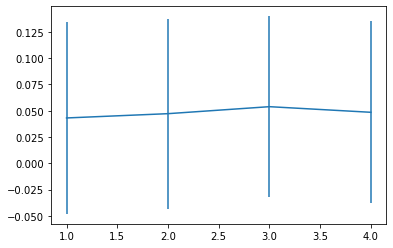

In [134]:
x = [1,2,3,4]
plt.errorbar(x, vals, stds)



In [115]:
plt.errorbar?

In [178]:
df_grouped.head()

,site,text
0,cnbc.com,"with one simple tweet, elon musk shows a maste..."
1,fortune.com,tesla why tesla model 3 deliveries missed the ...
2,reuters.com,"january 3, 2018 / 10:06 am / updated 20 minute..."
3,wsj.com,"published: jan 4, 2018 10:32 a.m. et share tw..."


In [8]:
df_comments = pd.read_pickle('/Users/josheverts/Documents/comments_dates.pkl')


In [162]:
scores = []
comment_count = 0
for i in range(len(df_comments)):
    
    for comment in df_comments.iloc[i]['comments']:
        tokens = word_tokenize(comment.lower())
        for token in tokens:
            if token in glove:
                sem_score = get_semaxis_score(glove, positive_terms, negative_terms, token)
                scores.append(sem_score)
        comment_count+=1
std = np.std(scores)
mean_score = np.mean(np.array(scores))
            
            
            

In [158]:
print(mean_score, std)


0.016785603 0.09496468


In [157]:
new_score_single(df_news, positive_terms, negative_terms)


(0.04964293, 0.083141364)

In [165]:
t_stat = (mean_score - .04964) / (np.sqrt(std**2/30000 + .08314**2/len(df_news)))



In [163]:
comment_count

1909

In [166]:
t_stat

-11.082940220415123

In [168]:
len(df_news)

1701

In [181]:
overall_comments = []
comment_count = 0
for i in range(len(df_comments)):
    
    for comment in df_comments.iloc[i]['comments']:
        tokens = word_tokenize(comment.lower())
        scores = []
        for token in tokens:
            if token in glove:
                vec = glove[token]
                scores.append(vec)
        if len(scores) > 0:
            overall_comments.append(np.mean(np.vstack(scores), axis = 0))


In [255]:
overall_articles = []
for i in range(len(df_news)):

    text = df_news.iloc[i].text
    tokens = word_tokenize(text.lower())
    scores = []
    for token in tokens:
        if token in glove:
            vec = glove[token]
            scores.append(vec)
    if len(scores) > 0:
            overall_articles.append(np.mean(np.vstack(scores), axis = 0))
    


In [180]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# pca_comments = []
# for embedding in overall_comments:
#     principalComponents = pca.fit_transform(embedding)
#     pca_comments.append(pr)






In [191]:
# principalComponents = pca.fit_transform(overall_comments[0].reshape(len(overall_comments[0]),1))

In [206]:
comments = pca.fit_transform(overall_comments)[:,:2]



In [207]:
xvals = comments[:,0]
yvals = comments[:,1]
# zvals = comments[:,2]

In [208]:
articles = pca.fit_transform(overall_articles)[:,:2]

In [209]:
xvals_article = articles[:,0]
yvals_article = articles[:,1]
# zvals_article = articles[:,2]

In [247]:
## test against random news
texts = []
from random import randint
random_article_nums = [randint(0,55000) for i in range(1800)]

for num in random_article_nums:
    
    count = 7 - len(str(num))
    num_str = ''
    while count > 0: ## add 0 to file number for specified format
        num_str+='0'
        count-=1
    num_str+=str(num)   
    filepath = '/Users/josheverts/Downloads/News Article/2018_01/news_' + num_str + '.json'
    
    try:
        with open(str(filepath), 'r') as f:
            file = json.load(f)
            title = file['title']
            text = file['text']
            date = file['published']
            site = file['thread']['site']
            texts.append(text)

    except:
        continue


    

In [274]:
overall_randoms = []
for text in texts:
    
    tokens = word_tokenize(text.lower())
    random_scores = []
    for token in tokens:
        if token in glove:
            vec = glove[token]
            random_scores.append(vec)
    if len(random_scores) > 0:
        overall_randoms.append(np.mean(np.vstack(random_scores), axis = 0))
    

In [290]:
randoms = pca.fit_transform(overall_randoms)[:,:2]
xvals_random = randoms[:,0]
yvals_random = randoms[:,1]


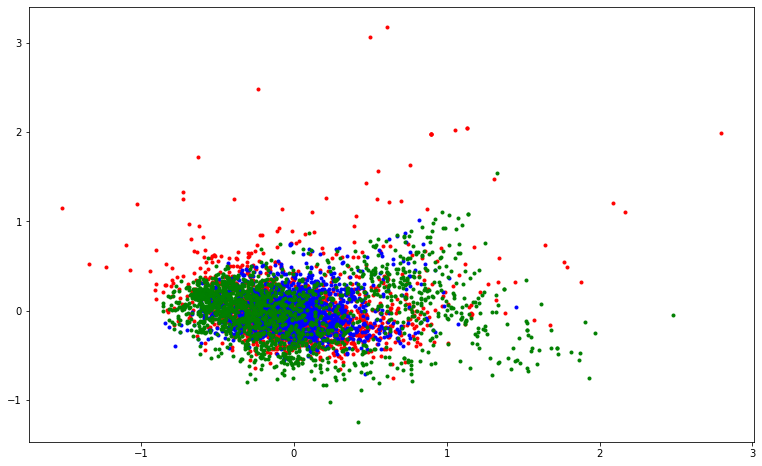

In [291]:
fig, ax = plt.subplots(1,1,figsize = (13,8))
ax.plot(xvals,yvals,'.', c = 'r')
ax.plot(xvals_article,yvals_article,'.', c = 'b')
ax.plot(xvals_random,yvals_random,'.', c = 'g')

array([ 0.48753989,  0.47461992, -0.14124544, ..., -0.65345946,
       -0.07023099,  0.13941264])

Text(0.5, 0, 'z')

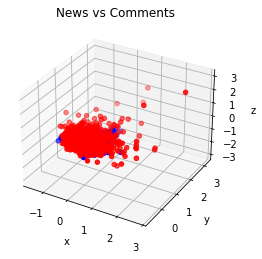

In [200]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xvals, yvals, zvals, c = 'r')
ax.scatter(xvals_article, yvals_article, zvals_article, c = 'b')

ax.set_title("News vs Comments")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


In [212]:
## calculate cohen's kappa for the gold data 
import pandas as pd
df_gold = pd.read_csv('/Users/josheverts/Documents/combined-GOLD-EV-Text-Josh-Xuan-labeled.csv')

In [214]:
df_gold.tail()

,Unnamed: 0,Josh,Xuan,text,date
95,956,-1,-1,gookthe goal was always 10k cars per week by e...,"Oct 29, 2018"
96,1328,-1,-1,detroit (reuters) - most major automakers on t...,2018-05-01T18:10:00.000+03:00
97,763,-1,1,bwtal gap going left of the light shows that t...,"Jul 30, 2018"
98,266,0,0,One of the better reviewers who reviews every ...,"Apr 1, 2020"
99,1474,-1,-1,(corrects sterling anderson item to say he lef...,2018-05-15T21:49:00.000+03:00


In [27]:
from sklearn.metrics import cohen_kappa_score

In [28]:
score = cohen_kappa_score(df_gold['Josh'], df_gold['Xuan'])

In [29]:
score

0.7878466434308229

In [14]:
df_gold.where?

In [36]:
df_gold = df_gold.where(df_gold['Josh'] == df_gold['Xuan']).dropna()
df_gold = df_gold.where(df_gold['Josh'] != 0).dropna()

In [43]:
df_gold.groupby(df_gold['Josh']).count()

,Unnamed: 0,Xuan,text,date
Josh,,,,
-1.0,34,34,34,34
1.0,26,26,26,26


In [ ]:
## positive: 26/60
## negative: 34/60 

In [46]:
%cd
df_gold.to_csv('df_gold_cleaned.csv')

/Users/josheverts
